In [1]:
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
import json
import numpy as np
from adjustText import adjust_text

from utils import (
    get_list_datasets, get_list_exp, load_json, URL_ROOT, get_data_labels,
)
from plots import plot_true_diff

/home/natacha/.cache/pypoetry/virtualenvs/clusterexp-s4OGTNKW-py3.11/lib/python3.11/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [2]:
f_artificial = "./res/analysis_datasets-artificial.json"
f_real = "./res/analysis_datasets-real-world.json"
PATH_ROOT_RES = "/home/natacha/Documents/Work/PhD_Archives/PhD_results/ClusterExp-res-final-2024-09-12/"

d_artificial = load_json(f_artificial)
d_real = load_json(f_real)
n_total_artificial = len(d_artificial)
n_total_real = len(d_real)
print(n_total_artificial)

113


In [3]:
def count_successful_dataset(dict_analysis: dict) -> int:
    """
    Count the number of successful datasets.

    Parameters
    ----------
    dict_analysis : dict
        The dictionary containing the result of analysis the datasets.

    Returns
    -------
    int
        The number of successful datasets.
    """
    n_success = 0
    for dataset, d_dataset in dict_analysis.items():
        if d_dataset["success"]:
            n_success += 1
    return n_success

print(count_successful_dataset(d_artificial))
print(count_successful_dataset(d_real))

104
14


Based on output above enough datasets are "successful" (i.e. the correct number of cluster was selected at least once by one of the CVI for one of the clustering method)

________________

In [4]:
def find_best_VI_true(
    dict_analysis: dict,
) -> List[float]:
    """
    For each dataset, find the best VI_true among the clustering methods.

    Parameters
    ----------
    dict_analysis : dict
        The dictionary containing the result of analysis the datasets.

    Returns
    -------
    List[float]
        The best VI_true among the clustering methods for each dataset.
    """
    best_VI_true = []
    for dataset, d_dataset in dict_analysis.items():
        all_VI_true = []
        for algo, d_algo in d_dataset["exps"].items():
            all_VI_true.append(d_algo["VI_true"])
        best_VI_true.append(min(all_VI_true))
    return best_VI_true


best_VI_artificial = find_best_VI_true(d_artificial)
best_VI_real = find_best_VI_true(d_real)
print(best_VI_artificial)
print(best_VI_real)

def count_successful_VI_true(
    dict_analysis: dict,
    VI_max: float = 0.2
) -> Tuple[List[float], int]:
    """
    Count the number of datasets with a high enough VI_true.

    Parameters
    ----------
    dict_analysis : dict
        The dictionary containing the result of analysis the datasets.
    VI_max : float
        The VI_true threshold.

    Returns
    -------
    Tuple[List[float], int]
        The number of successful datasets (VI_true < VI_max).
    """
    best_VI_true = find_best_VI_true(dict_analysis)
    successful_VIs = [VI for VI in best_VI_true if VI < VI_max]
    n_success = len(successful_VIs)
    return successful_VIs, n_success

print(count_successful_VI_true(d_artificial)[-1])
print(count_successful_VI_true(d_real)[-1])

[4.440892098500626e-16, 0.0, 1.7902639571521097, 0.8840795570630834, 4.440892098500626e-16, 0.0, 1.0080095506555575, 0.9852354243361205, 2.5569819304138335, 0.0, 0.474686900995485, 0.06388671146613678, 0.0, 0.0, 0.8916688918236316, 0.2848768857725341, 1.0042809628080178, 1.0067118286062033, 1.412821728690472, 1.3381509364176174, 0.8581013970382853, 1.0794411436559654, 0.2909428573374311, 2.8270946523047886, 0.7736085052946907, 0.7817849058774082, 0.0, 1.8248987318829961, 0.21931799517620298, 0.4386298663059405, 0.0, 0.2175317608971139, 0.12026787424531626, 0.27310969285298414, 1.3192382078391987, 1.6030277802434907, 0.08750629422551048, 0.40521256114043025, 0.0, 0.4676036446098051, 1.7763568394002505e-15, 0.0, 0.0, 0.0, -0.0, 0.8976068803367786, 0.0, 1.0094063135980398, 0.0, 0.0813601502764083, 0.2585444724357546, 0.7805625185457785, 0.0, 0.0, 0.0, 0.7251616758843825, 0.0, 0.0, 1.0094063135980398, 0.0, 0.0, 0.0, 0.2773610081359177, -8.881784197001252e-16, 0.0, 0.26883572300971803, 1.32

In [5]:
print(count_successful_VI_true(d_artificial, VI_max=0.1)[-1])
print(count_successful_VI_true(d_real, VI_max=0.6)[-1])

53
2


- Based on the output above, it seems like none of the real dataset was well enough clustered by the clustering method, evem when assuming the correct number of clusters (and even if the correct clustering was still somehow correctly selected by some CVIs)
- Half of the toy datasets seem to be well enough clustered, while the other half is not.

________________________________________

Text(0.5, 1.0, 'Distribution of VI_k_true ')

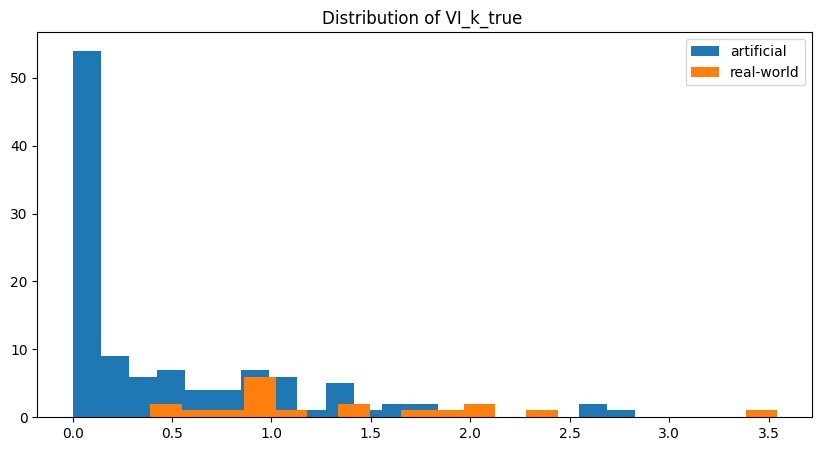

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

ax.hist(best_VI_artificial, bins= 20, label="artificial")
ax.hist(best_VI_real, bins= 20, label="real-world")
ax.legend()
ax.set_title("Distribution of VI_k_true ")

We can see that there is a huge difference between the VI of the artificial datasets and the real-world datasets. Unfortunately, due to the fact that the real-world data has high dimensions, it is hard to visualise how acceptable the VI values are. But based on VI values on artificial datasets and their corresponding visualisation, we can assume that none of the real-world clustering are actually good enough.

________________________________________

Text(0.5, 1.0, 'Frequency of k_true')

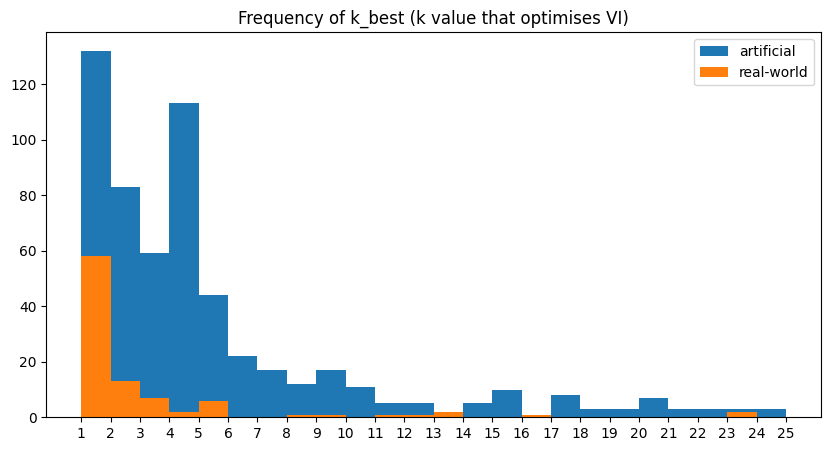

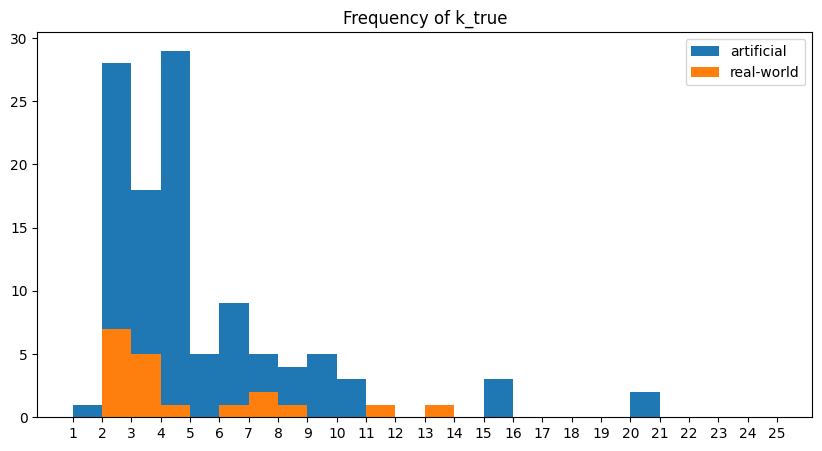

In [7]:
def distrib_k_best(dict_analysis : dict) -> List[int]:
    """
    For each experiment, find the k_best (k that minimizes VI)

    Parameters
    ----------
    dict_analysis : dict
        The dictionary containing the result of analysis the datasets.

    Returns
    -------
    List[int]
        A flattened list of k_best for all experiments
    """
    list_k_best = []
    for dataset, d_dataset in dict_analysis.items():
        list_k_best += d_dataset["k_best"]
    list_k_best = [int(k) for k in list_k_best]
    return list_k_best

def distrib_k_true(dict_analysis : dict) -> List[int]:
    """
    For each experiment, find the k_best (k that minimizes VI)

    Parameters
    ----------
    dict_analysis : dict
        The dictionary containing the result of analysis the datasets.

    Returns
    -------
    List[int]
        A flattened list of k_best for all experiments
    """
    list_k_true = []
    for dataset, d_dataset in dict_analysis.items():
        list_k_true.append(d_dataset["k_true"])
    list_k_true = [int(k) for k in list_k_true]
    return list_k_true

k_best_artificial = distrib_k_best(d_artificial)
k_best_real = distrib_k_best(d_real)

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(sorted(k_best_artificial), bins= range(1,26), label="artificial")
ax.hist(sorted(k_best_real), bins= range(1,26), label="real-world")
ax.set_xticks(range(1,26))
ax.legend()
ax.set_title("Frequency of k_best (k value that optimises VI)")


k_true_artificial = distrib_k_true(d_artificial)
k_true_real = distrib_k_true(d_real)

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(sorted(k_true_artificial), bins= range(1,26), label="artificial")
ax.hist(sorted(k_true_real), bins= range(1,26), label="real-world")
ax.set_xticks(range(1,26))
ax.legend()
ax.set_title("Frequency of k_true")

- The peaks visible in the k_true are also visible in k_best. This means that the clusterings assuming the correct number of clusters also give the best VI values. 
- There is however one difference: The peak for k = 2 is higher for k_true than for k_best and it seems to be shifted to k_best = 1 instead. The could be a good thing or not so bad thing, if the case with k_true = 2 are actually very noisy / imbalanced / subclusters, etc. This could show that k = 1 could be a relevant option as well. To be further investigated with plotted examples.

_______________________________________________________

Text(0.5, 1.0, 'Distribution of VI_k_true in case of success')

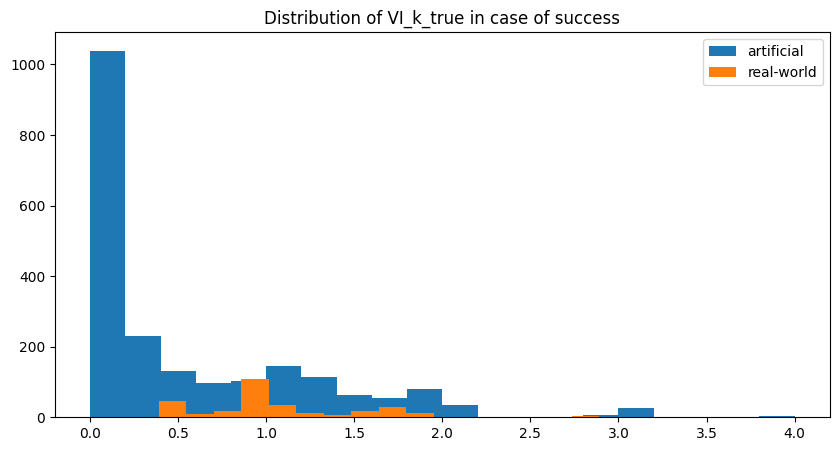

In [8]:
def VI_success(
    dict_analysis: dict
) -> Tuple[List[float], Dict[str, List[float]]]:
    """
    Find VI_k_true for all successful experiments.

    Parameters
    ----------
    dict_analysis : dict
        The dictionary containing the result of analysis the datasets.

    Returns
    -------
    Tuple[List[float], Dict[str, List[float]]]
        VI_k_true for all successful experiments, and then CVI by CVI.
    """
    all_VI_success = []
    VI_success_cvi = {}
    for dataset, d_dataset in dict_analysis.items():
        for cvi, d_cvi in d_dataset["CVIs"].items():
            VI_success_cvi[cvi] = []
    for dataset, d_dataset in dict_analysis.items():
        for cvi, d_cvi in d_dataset["CVIs"].items():
            VI_kept = [
                vi for i, vi in enumerate(d_cvi["VIs_true"])
                if d_cvi["success"][i]
            ]
            all_VI_success += VI_kept
            VI_success_cvi[cvi] += VI_kept

    return all_VI_success, VI_success_cvi

VI_success_artificial, VI_success_cvi_artificial = VI_success(d_artificial)
VI_success_real, VI_success_cvi_real = VI_success(d_real)


fig, ax = plt.subplots(figsize=(10,5))

ax.hist(VI_success_artificial, bins= 20, label="artificial")
ax.hist(VI_success_real, bins= 20, label="real-world")
ax.legend()
ax.set_title("Distribution of VI_k_true in case of success")

Text(0.5, 1.0, 'Distribution of VI_k_true in case of success. Percentages')

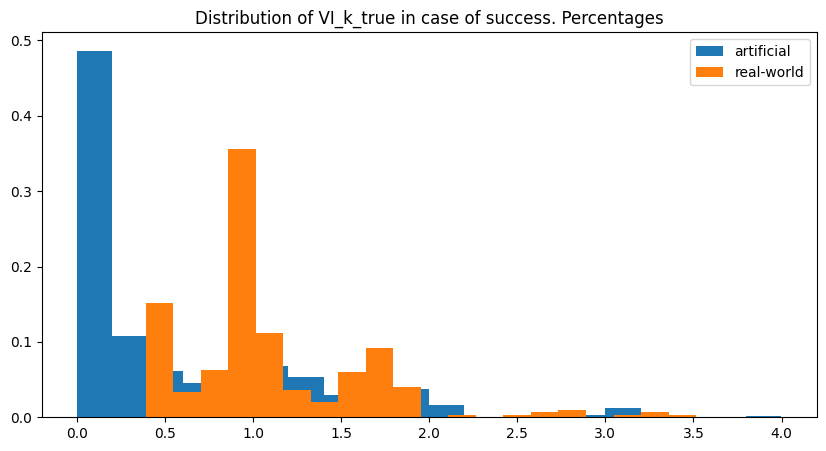

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

n_success = len(VI_success_artificial)
weights = [1/n_success]*n_success
ax.hist(VI_success_artificial, weights=weights, bins= 20, label="artificial")

n_success = len(VI_success_real)
weights = [1/n_success]*n_success
ax.hist(VI_success_real, weights=weights, bins= 20, label="real-world")
ax.legend()
ax.set_title("Distribution of VI_k_true in case of success. Percentages")

In [10]:
def distrib_VI(
    source_number: int = 0,
    k_true: int = None,
    only_k_true: bool = False,
    VI_max: float = None,
    verbose: bool = False,
) -> Dict[str, List[float]]:
    """
    Find the VI distribution with respect to k.

    The VI used here is between the true clustering (with all different
    k_true values unless k_true is not None) and each clustering
    obtained with the different clustering methods (so not necessarily
    with k_true, unless only_k_true is True).

    Parameters
    ----------
    source_number : int, optional
        The source number (["artificial", "real-world", "UCR"])
    k_true : int, optional
        Filter experiments by k_true. If k_true is None, then all
        experiments are used. Default to None.
    only_k_true : bool, optional
        Filter VIs so that only the VIs of clusterings assuming k_true
        are taken into account. Default to False.
    VI_max : float, optional
        Filter experiments so that, only those with a VI_true <= VI_max
        are taken into account. if VI_max is None, then there is no
        filtering. Default to None.
    verbose : bool, optional
        Verbosity level.

    Returns
    -------
    Dict[str, List[float]]
        For each k, the complete list of VI values.
    """
    VI_distrib = {}

    sources = ["artificial", "real-world", "UCR"]
    DATA_SOURCE = sources[source_number]
    RES_DIR = PATH_ROOT_RES + f'{DATA_SOURCE}/'
    FNAME_DATASET_EXPS = f"datasets_experiments_theory-{DATA_SOURCE}.txt"

    datasets = get_list_datasets(RES_DIR + FNAME_DATASET_EXPS)

    for d in datasets:

        # ----------- Going through all clustering methods -------------
        # For each dataset, find all experiments working on this dataset
        # but using different clustering methods (by filtering on the
        # filename)
        fnames = get_list_exp(
            dataset_name=d, res_dir=RES_DIR, suffix="_scored.json"
        )

        for fname in fnames:

            with open(RES_DIR + fname + ".json") as f_json:
                exp = json.load(f_json)

            if k_true is not None and int(exp["k"]) != k_true:
                continue

            true_k = str(exp["k"])
            vi_true = exp["VIs"][true_k]
            if VI_max is not None and vi_true > VI_max:
                continue

            if only_k_true:

                if vi_true is not None:
                    if true_k in VI_distrib:
                        VI_distrib[true_k].append(vi_true)
                    else:
                        VI_distrib[true_k] = [vi_true]
                else:
                    print("Is None")
            else:
                # VI of each assumption k for this clustering method
                for k, vi in exp["VIs"].items():

                    if vi is not None:
                        if k in VI_distrib:
                            VI_distrib[k].append(vi)
                        else:
                            VI_distrib[k] = [vi]
                    else:
                        print("Is None")
    if verbose:
        for k, vis in VI_distrib.items():
            print(k, len(vis), min(vis))
    return VI_distrib

In [11]:
VI_distrib_artificial = distrib_VI(0, k_true=4, VI_max=0.2, verbose=True)

0 41 1.6804820237218405
1 41 1.6804820237218405
2 41 0.7829855649792172
3 41 0.36572366863240013
4 41 -4.440892098500626e-16
5 41 0.00818213807758772
6 41 0.016361836733161716
7 41 0.024539090754272852
8 41 0.0327138949061494
9 41 0.047470089727483344
10 41 0.04905613255063912
11 41 0.057223555460793385
12 41 0.06538850733650392
13 41 0.07355098282920336
14 41 0.08171097656711979
15 41 0.0898684831551253
16 41 0.09811459315081539
17 41 0.10626960717027423
18 41 0.12098609288738604
19 41 0.12913359645198996
20 41 0.14383501177571167
21 41 0.15852632474380668
22 41 0.16666120027156994
23 41 0.17479353337933512
24 41 0.1829233184046859


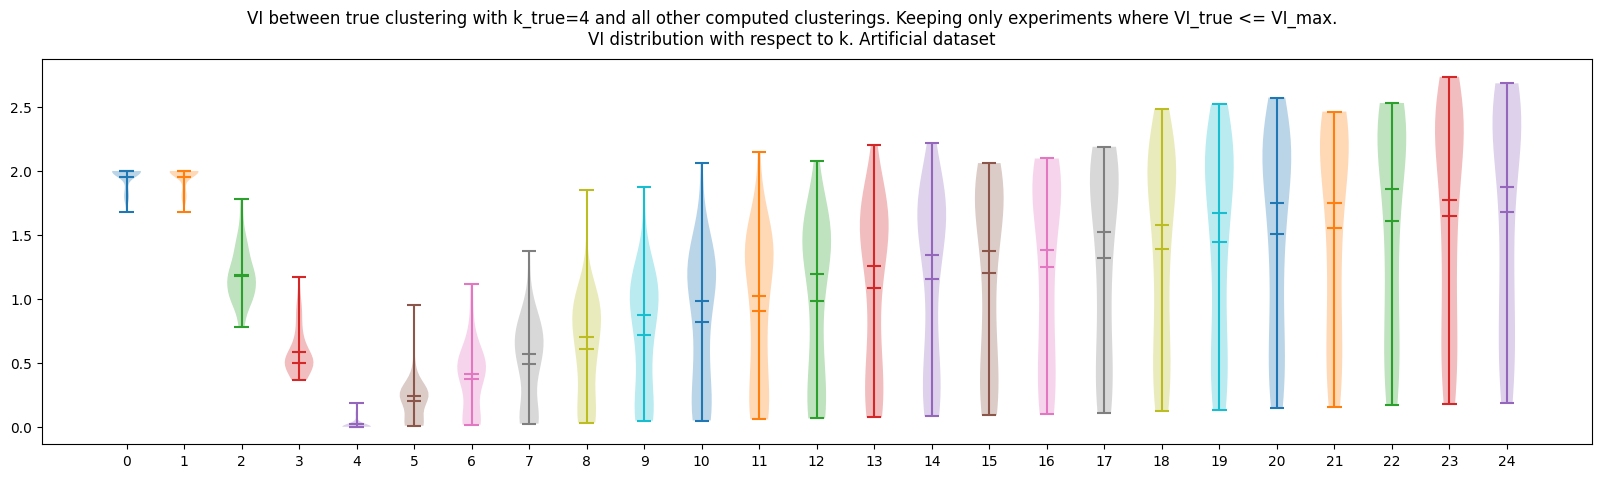

In [12]:
fig, ax = plt.subplots(figsize=(20,5))
for k, vis in VI_distrib_artificial.items():
    ax.violinplot(vis, positions=[int(k)], showmeans=True, showmedians=True, points=30)
title = (
    "VI between true clustering with k_true=4 and all other computed clusterings. Keeping only experiments where VI_true <= VI_max.\n"
    + "VI distribution with respect to k. Artificial dataset"
)
ax.set_xticks(range(25))
fig.suptitle(title)
plt.show()

- Note that the case k=0 and k=1 have exactly the same violin, because they have exactly the same VI, because VI doesn't pay attention to the distances between datapoints but just datapoints' belonging to a given cluster. The case k=0 and k=1 have exactly the same datapoint distribution among the clusters (all datapoints in one cluster)
_________________________________

In [13]:
VI_distrib_artificial = distrib_VI(0, k_true=2, VI_max=0.2, verbose=True)

0 39 0.7219280948873623
1 39 0.7219280948873623
2 39 0.0
3 39 0.0022785605733695036
4 39 0.005239587145301261
5 39 0.007859184236552519
6 39 0.010507618402503471
7 39 0.013127084429828795
8 39 0.01574641933591847
9 39 0.018365623063414827
10 39 0.023246420224372732
11 39 0.025865492715867022
12 39 0.02848443391390032
13 39 0.03110324376096374
14 39 0.03375132065015363
15 39 0.03639927835243517
16 39 0.03901795679096898
17 39 0.04163650376336325
18 39 0.04850301868199636
19 39 0.05115085714997769
20 39 0.05172347978605418
21 39 0.05858880943060929
22 39 0.061236528616863684
23 39 0.06180915125293973
24 39 0.06445675111000115


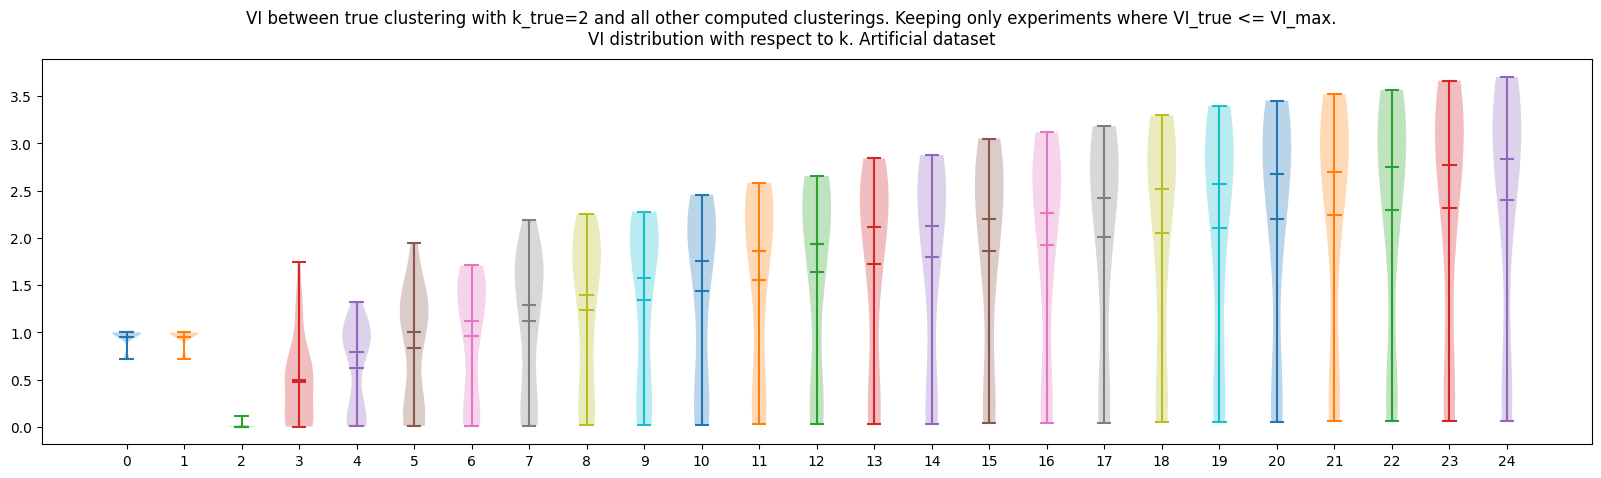

In [14]:
fig, ax = plt.subplots(figsize=(20,5))
for k, vis in VI_distrib_artificial.items():
    ax.violinplot(vis, positions=[int(k)], showmeans=True, showmedians=True, points=30)
title = (
    "VI between true clustering with k_true=2 and all other computed clusterings. Keeping only experiments where VI_true <= VI_max.\n"
    + "VI distribution with respect to k. Artificial dataset"
)
ax.set_xticks(range(25))
fig.suptitle(title)
plt.show()

In [15]:
VI_distrib_artificial = distrib_VI(0, k_true=15, VI_max=0.2, verbose=True)

0 6 3.9051305673219483
1 6 3.9051305673219483
2 6 2.913970476706698
3 6 2.4123078558388014
4 6 2.018968826384589
5 6 1.7241284097072818
6 6 1.4069987597456919
7 6 1.2171135760303535
8 6 0.9490740305259493
9 6 0.8168514278622308
10 6 0.700459151304619
11 6 0.5820730446091016
12 6 0.3999999999999986
13 6 0.2666666666666657
14 6 0.15588157608952002
15 6 0.04142423712225174
16 6 0.07221911526571922
17 6 0.0817707404722352
18 6 0.08529434649109469
19 6 0.08332863511023714
20 6 0.08948888538284372
21 6 0.09302802413962041
22 6 0.09342715765481113
23 6 0.09698636577861475
24 6 0.1068578450599782


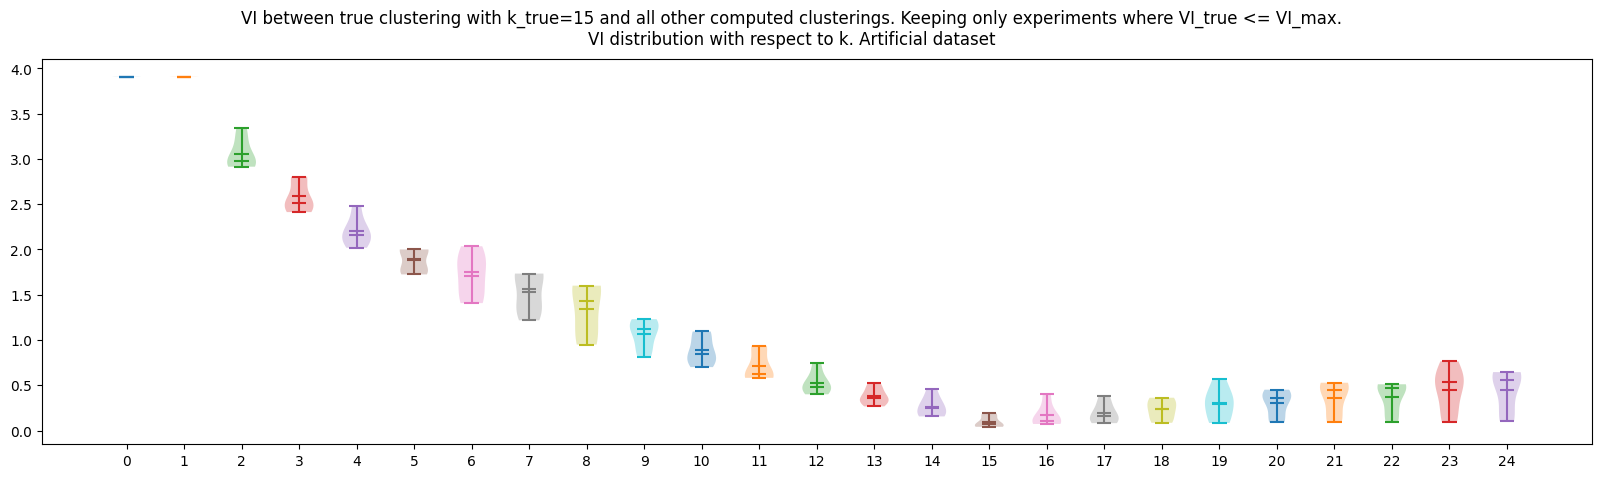

In [16]:
fig, ax = plt.subplots(figsize=(20,5))
for k, vis in VI_distrib_artificial.items():
    ax.violinplot(vis, positions=[int(k)], showmeans=True, showmedians=True, points=30)
title = (
    "VI between true clustering with k_true=15 and all other computed clusterings. Keeping only experiments where VI_true <= VI_max.\n"
    + "VI distribution with respect to k. Artificial dataset"
)
ax.set_xticks(range(25))
fig.suptitle(title)
plt.show()

## Note

From Meila: 

> "Splitting (or merging) smaller clusters has less impact on the VI than splitting or merging larger ones" 

## Tables 



In [17]:
f_CVI_artificial = "./res/analysis_CVIs-artificial.json"
d_cvi_artificial = load_json(f_CVI_artificial)
n_exps_artificial = n_total_artificial * 5
n_exps_artificial

565

In [18]:
def make_table(dict_cvi : dict, n_exps: int = None) -> None:
    """
    For each CVI, get the %k_success, mean quality and ration %k / quality

    Parameters
    ----------
    dict_cvi : dict
        The dictionary containing the result of analysis the CVIs.
    n_exps : int
        The total number of experiments (n_datasets x n_clustering_methods)
    """
    print(f"| CVI |  % k correctly selected | Mean quality | Quality / #k correctly selected |")
    print(f"| --- | :---------------------: | :----------: | :----------------: |")
    for cvi, d_cvi in dict_cvi["CVIs"].items():
        per_k_success = d_cvi["acc"]*100 / n_exps
        mean_quality = d_cvi["quality"] / n_exps
        ratio = d_cvi["quality"] / d_cvi["acc"]
        print(f" |{str(cvi)} | {per_k_success:.3f} | {mean_quality:.3f} | {ratio:.2f} |")


In [41]:
def table_as_scatter(
    texts : List[str],
    per_k_success: List[float],
    mean_quality: List[float],
) -> int:
    """
    _summary_

    Parameters
    ----------
    texts : List[str]
        The text to annotate each datapoint
    per_k_success : List[float]
        Percentage of correctly selected number of clusters
    mean_quality : List[float]
        Mean quality of the selected clustering

    Returns
    -------
    A matplotlib figure and ax.
        The matplotlib figure containing the plot
    """
    fig, ax = plt.subplots(figsize=(8,5))
    annotations = []
    for (x, y, t) in zip(per_k_success, mean_quality, texts):

        ax.scatter(per_k_success, mean_quality, c="gray")
        annotations.append(plt.text(x, y, t))


    adjust_text(annotations,
            only_move={'points':'y', 'text':'y'},
            #force_points=0.15,
            arrowprops=dict(arrowstyle="-", color='r', lw=0.5)
            )

    plt.xlabel("% k correctly selected")
    plt.ylabel("Mean quality")

    return fig, ax


In [20]:
make_table(d_cvi_artificial, n_exps_artificial)

| CVI |  % k correctly selected | Mean quality | Quality / #k correctly selected |
| --- | :---------------------: | :----------: | :----------------: |
 |Hartigan_monotonous | 27.965 | 0.228 | 0.82 |
 |Hartigan_original | 13.097 | 0.171 | 1.31 |
 |CalinskiHarabasz_monotonous | 12.566 | 0.179 | 1.43 |
 |CalinskiHarabasz_original | 26.195 | 0.244 | 0.93 |
 |GapStatistic_monotonous | 27.611 | 0.243 | 0.88 |
 |GapStatistic_original | 17.168 | 0.202 | 1.17 |
 |Silhouette | 24.602 | 0.262 | 1.07 |
 |ScoreFunction | 14.159 | 0.179 | 1.27 |
 |MaulikBandyopadhyay_absolute | 26.549 | 0.269 | 1.01 |
 |MaulikBandyopadhyay_monotonous | 30.973 | 0.215 | 0.69 |
 |SD | 1.062 | 0.082 | 7.75 |
 |SDbw | 9.381 | 0.160 | 1.71 |
 |Dunn | 21.239 | 0.241 | 1.13 |
 |XB | 30.619 | 0.261 | 0.85 |
 |XB_star | 35.044 | 0.264 | 0.75 |
 |DB | 24.779 | 0.138 | 0.56 |
 |Inertia_sum | 16.637 | 0.148 | 0.89 |
 |Diameter_max | 18.407 | 0.195 | 1.06 |


In [44]:
texts = []
per_k_success = []
mean_quality = []
for cvi, d_cvi in d_cvi_artificial["CVIs"].items():
    texts.append(str(cvi))
    per_k_success.append(d_cvi["acc"]*100 / n_exps_artificial)
    mean_quality.append(d_cvi["quality"] / n_exps_artificial)

Text(0.5, 1.0, 'Using all experiments')

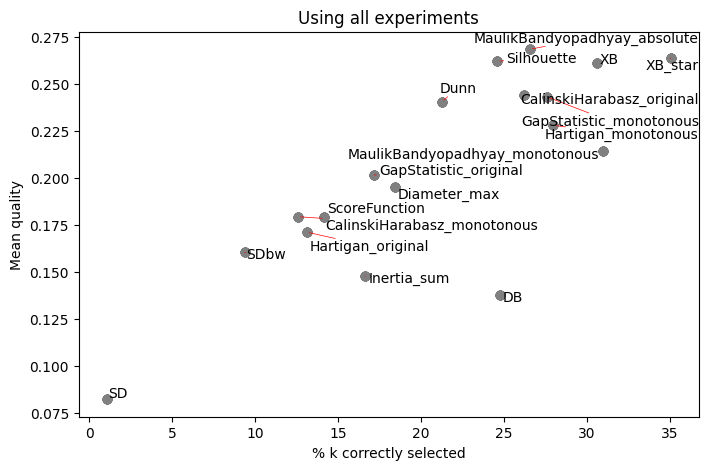

In [45]:
fig, ax = table_as_scatter(texts, per_k_success, mean_quality)
plt.title("Using all experiments")


In [46]:
def make_table_VI(
    v1 : float = 0.1,
    v2 : float = 1,
    source_number : int = 0,
) -> Dict[str, Dict]:
    """
    Sort each experiments by VI_true range and number CVI selection success

    Parameters
    ----------
    v1 : float
        The first VI_true threshold value.
    v2 : float
        The second VI_true threshold value.
    source_number : int, optional
        The source number (["artificial", "real-world", "UCR"])

    Returns
    -------
    Dict[str, Dict]
        For each VI_true range, a dictionary containing the list of experiments and for each successful/unsuccessful case, the list of CVI
    """
    # Sort experiments by VI_true ranges and for each range sort by success


    table = {
        "min" : {"exps" : {}, True : 0, False : 0},
        "middle" : {"exps" : {}, True : 0, False : 0},
        "max" : {"exps" : {}, True : 0, False : 0},
        "v1" : v1,
        "v2" : v2,
    }

    sources = ["artificial", "real-world", "UCR"]
    DATA_SOURCE = sources[source_number]
    RES_DIR = PATH_ROOT_RES + f'{DATA_SOURCE}/'
    FNAME_DATASET_EXPS = f"datasets_experiments_theory-{DATA_SOURCE}.txt"

    datasets = get_list_datasets(RES_DIR + FNAME_DATASET_EXPS)

    for d in datasets:

        # ----------- Going through all clustering methods -------------
        # For each dataset, find all experiments working on this dataset
        # but using different clustering methods (by filtering on the
        # filename)
        fnames = get_list_exp(
            dataset_name=d, res_dir=RES_DIR, suffix="_scored.json"
        )

        for fname in fnames:

            with open(RES_DIR + fname + ".json") as f_json:
                exp = json.load(f_json)

            true_k = str(exp["k"])
            vi_true = exp["VIs"][true_k]

            # Find out in which VI_true range the experiment belongs
            if vi_true < v1:
                vi_range = "min"
            elif vi_true >= v2:
                vi_range = "max"
            else:
                vi_range = "middle"

            # For this exp, have a dict that has detailed info for each CVI
            table[vi_range]["exps"][fname] = {
                "VI" : vi_true,
                True : [], False : [],
            }

            # Update CVI dict and number of success/fail for this VI range
            for cvi, cvi_info in exp["CVIs"].items():
                is_success = str(cvi_info["selected"]) == true_k
                table[vi_range]["exps"][fname][is_success].append(cvi, )
                table[vi_range][is_success] += 1

    return table




In [47]:
def print_table_VI(table_VI: dict):
    """Write a markdown table out of make_table_VI's output"""
    v1 = table_VI["v1"]
    v2 = table_VI["v2"]
    print(f"|    | VI < {v1} | {v1} <= VI < {v2} | {v2} <= VI |")
    print(f"| -- | :-------: | :---------------: | :--------: |")
    print(f'| #Success | {table_VI["min"][True]} | {table_VI["middle"][True]} | {table_VI["max"][True]} |')
    print(f'| #Fail    | {table_VI["min"][False]} | {table_VI["middle"][False]} | {table_VI["max"][False]} |')
    print(f'| #Total   | {table_VI["min"][True] + table_VI["min"][False]} | {table_VI["middle"][False] + table_VI["middle"][False]} | {table_VI["max"][False] + table_VI["max"][False]} |')

In [48]:
def show_dataset_table_VI(table_VI: dict):
    """Show list of experiments out of make_table_VI's output"""
    v1 = table_VI["v1"]
    v2 = table_VI["v2"]
    msg1 = f"               VI_true < {v1}              "
    msg2 = f"            {v1} <= VI_true < {v2}         "
    msg3 = f"              {v2} <= VI_true              "
    msgs = [msg1, msg2, msg3]
    ranges = ["min", "middle", "max"]
    for msg, category in zip(msgs, ranges):
        print(f" -------- Computed clusterings with: ------")
        print(msg)
        for exp, exp_info in table_VI[category]["exps"].items():
            print(f'{exp_info["VI"]:<24}', exp)


In [49]:
table_VI = make_table_VI(0.1, 0.6)
print_table_VI(table_VI)

|    | VI < 0.1 | 0.1 <= VI < 0.6 | 0.6 <= VI |
| -- | :-------: | :---------------: | :--------: |
| #Success | 976 | 424 | 736 |
| #Fail    | 1310 | 980 | 5834 |
| #Total   | 2286 | 1960 | 11668 |


In [50]:
show_dataset_table_VI(table_VI)

 -------- Computed clusterings with: ------
               VI_true < 0.1              
4.440892098500626e-16    AgglomerativeClustering-Single_None/long3.arff_scored
4.440892098500626e-16    KMeans_None/long3.arff_scored
4.440892098500626e-16    AgglomerativeClustering-Average_None/long3.arff_scored
4.440892098500626e-16    SpectralClustering_None/long3.arff_scored
0.0                      AgglomerativeClustering-Single_None/zelnik1.arff_scored
4.440892098500626e-16    AgglomerativeClustering-Single_None/disk-4000n.arff_scored
0.0                      AgglomerativeClustering-Single_None/cure-t0-2000n-2D.arff_scored
0.0                      AgglomerativeClustering-Single_None/zelnik3.arff_scored
0.06388671146613678      AgglomerativeClustering-Average_None/aggregation.arff_scored
0.0                      AgglomerativeClustering-Single_None/donutcurves.arff_scored
0.0                      AgglomerativeClustering-Single_None/dartboard1.arff_scored
0.0                      AgglomerativeClu

In [51]:
table_VI = make_table_VI(0.2, 0.5)
print_table_VI(table_VI)

|    | VI < 0.2 | 0.2 <= VI < 0.5 | 0.5 <= VI |
| -- | :-------: | :---------------: | :--------: |
| #Success | 1039 | 316 | 781 |
| #Fail    | 1409 | 692 | 6023 |
| #Total   | 2448 | 1384 | 12046 |


In [52]:
show_dataset_table_VI(table_VI)

 -------- Computed clusterings with: ------
               VI_true < 0.2              
4.440892098500626e-16    AgglomerativeClustering-Single_None/long3.arff_scored
4.440892098500626e-16    KMeans_None/long3.arff_scored
4.440892098500626e-16    AgglomerativeClustering-Average_None/long3.arff_scored
4.440892098500626e-16    SpectralClustering_None/long3.arff_scored
0.0                      AgglomerativeClustering-Single_None/zelnik1.arff_scored
4.440892098500626e-16    AgglomerativeClustering-Single_None/disk-4000n.arff_scored
0.0                      AgglomerativeClustering-Single_None/cure-t0-2000n-2D.arff_scored
0.0                      AgglomerativeClustering-Single_None/zelnik3.arff_scored
0.06388671146613678      AgglomerativeClustering-Average_None/aggregation.arff_scored
0.0                      AgglomerativeClustering-Single_None/donutcurves.arff_scored
0.0                      AgglomerativeClustering-Single_None/dartboard1.arff_scored
0.0                      AgglomerativeClu

In [53]:
exp_examples = [
    # VI < 0.1
    "AgglomerativeClustering-Average_None/elliptical_10_2.arff_scored",
    "KMeans_None/s-set1.arff_scored",
    "KMedoids_None/xclara.arff_scored",
    "SpectralClustering_None/triangle1.arff_scored",
    # 0.1 <= VI < 0.6
    # Good
    "SpectralClustering_None/flame.arff_scored",
    "KMeans_None/DS-850.arff_scored",
    # Bad
    "AgglomerativeClustering-Single_None/aml28.arff_scored",
    "AgglomerativeClustering-Single_None/complex8.arff_scored",
    # 0.6 <= VI
    "KMeans_None/longsquare.arff_scored",
    "KMedoids_None/elliptical_10_2.arff_scored",
    "AgglomerativeClustering-Single_None/diamond9.arff_scored"
]

# Sort true clusters from the biggest to the smallest
# For each true cluster, find the generated cluster that has the biggest intersection
# Give to the intersection the same label as the true cluster label
# remove this generated cluster from the future candidates
# For each datapoint that is either in the true cluster or the generated cluster but that isn't in the intersection, label them as "-1"
# Do this until we have gone through all the true clusters

In [54]:
source_number = 0
sources = ["artificial", "real-world", "UCR"]
DATA_SOURCE = sources[source_number]
PATH = f"{URL_ROOT}{DATA_SOURCE}/"
RES_DIR = PATH_ROOT_RES + f'{DATA_SOURCE}/'

def show_exp_examples(fname: str):

    print(f" ---------------- EXPERIMENT {fname} ---------------- ")

    # Format: METHOD_None/DATASET.arff_scored
    # And we want to extract DATASET.arff
    [folder, file] = fname.split("/")
    d = "_".join(file.split("_")[:-1])
    print(d)
    X, y, n_labels, meta = get_data_labels(d, path=PATH)
    classes = np.unique(y)
    print(len(y))

    # true clusters
    # List[List[int]]
    indices = np.arange(len(X))
    true_clusters = [
        indices[y == classes[i]] for i in range(n_labels)
    ]

    with open(RES_DIR + fname + ".json") as f_json:
        exp = json.load(f_json)

    true_k = str(exp["k"])
    vi_true = exp["VIs"][true_k]
    generated_clustering = exp["clusterings"][true_k]

    fig, misclassified = plot_true_diff(
        X, y, true_clusters, generated_clustering, VI_best=vi_true
    )
    fig.savefig("../notes/" + fname.replace("/", "_") + "-examples.png")
    return fig, misclassified

 ---------------- EXPERIMENT AgglomerativeClustering-Average_None/elliptical_10_2.arff_scored ---------------- 
elliptical_10_2.arff
500


/home/natacha/Documents/Work/PhD/TopEns/Code/ClusterExp/clusterexp/plots.py:129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_val, y_val, s=s, c=color)
/tmp/ipykernel_184408/3460142827.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


 ---------------- EXPERIMENT KMeans_None/s-set1.arff_scored ---------------- 
s-set1.arff
5000


/home/natacha/Documents/Work/PhD/TopEns/Code/ClusterExp/clusterexp/plots.py:129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_val, y_val, s=s, c=color)
/tmp/ipykernel_184408/3460142827.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


 ---------------- EXPERIMENT KMedoids_None/xclara.arff_scored ---------------- 
xclara.arff
3000


/home/natacha/Documents/Work/PhD/TopEns/Code/ClusterExp/clusterexp/plots.py:129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_val, y_val, s=s, c=color)
/tmp/ipykernel_184408/3460142827.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


 ---------------- EXPERIMENT SpectralClustering_None/triangle1.arff_scored ---------------- 
triangle1.arff
1000


/home/natacha/Documents/Work/PhD/TopEns/Code/ClusterExp/clusterexp/plots.py:129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_val, y_val, s=s, c=color)
/tmp/ipykernel_184408/3460142827.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


 ---------------- EXPERIMENT SpectralClustering_None/flame.arff_scored ---------------- 
flame.arff
240


/home/natacha/Documents/Work/PhD/TopEns/Code/ClusterExp/clusterexp/plots.py:129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_val, y_val, s=s, c=color)
/tmp/ipykernel_184408/3460142827.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


 ---------------- EXPERIMENT KMeans_None/DS-850.arff_scored ---------------- 
DS-850.arff
850


/home/natacha/Documents/Work/PhD/TopEns/Code/ClusterExp/clusterexp/plots.py:129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_val, y_val, s=s, c=color)
/tmp/ipykernel_184408/3460142827.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


 ---------------- EXPERIMENT AgglomerativeClustering-Single_None/aml28.arff_scored ---------------- 
aml28.arff
804


/home/natacha/Documents/Work/PhD/TopEns/Code/ClusterExp/clusterexp/plots.py:129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_val, y_val, s=s, c=color)
/tmp/ipykernel_184408/3460142827.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


 ---------------- EXPERIMENT AgglomerativeClustering-Single_None/complex8.arff_scored ---------------- 
complex8.arff
2551


/home/natacha/Documents/Work/PhD/TopEns/Code/ClusterExp/clusterexp/plots.py:129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_val, y_val, s=s, c=color)
/tmp/ipykernel_184408/3460142827.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


 ---------------- EXPERIMENT KMeans_None/longsquare.arff_scored ---------------- 
longsquare.arff
900


/home/natacha/Documents/Work/PhD/TopEns/Code/ClusterExp/clusterexp/plots.py:129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_val, y_val, s=s, c=color)
/tmp/ipykernel_184408/3460142827.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/natacha/Documents/Work/PhD/TopEns/Code/ClusterExp/clusterexp/plots.py:129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatte

 ---------------- EXPERIMENT KMedoids_None/elliptical_10_2.arff_scored ---------------- 
elliptical_10_2.arff
500


/tmp/ipykernel_184408/3460142827.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


 ---------------- EXPERIMENT AgglomerativeClustering-Single_None/diamond9.arff_scored ---------------- 
diamond9.arff
3000


/home/natacha/Documents/Work/PhD/TopEns/Code/ClusterExp/clusterexp/plots.py:129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_val, y_val, s=s, c=color)
/tmp/ipykernel_184408/3460142827.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


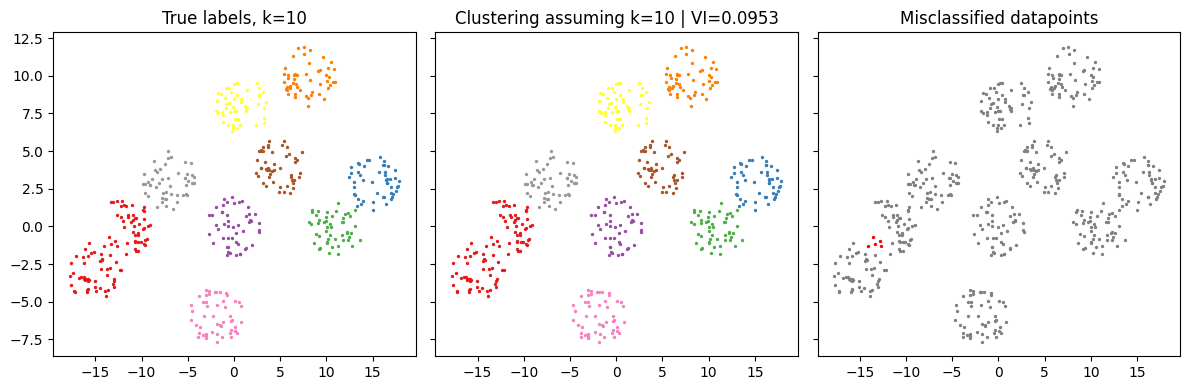

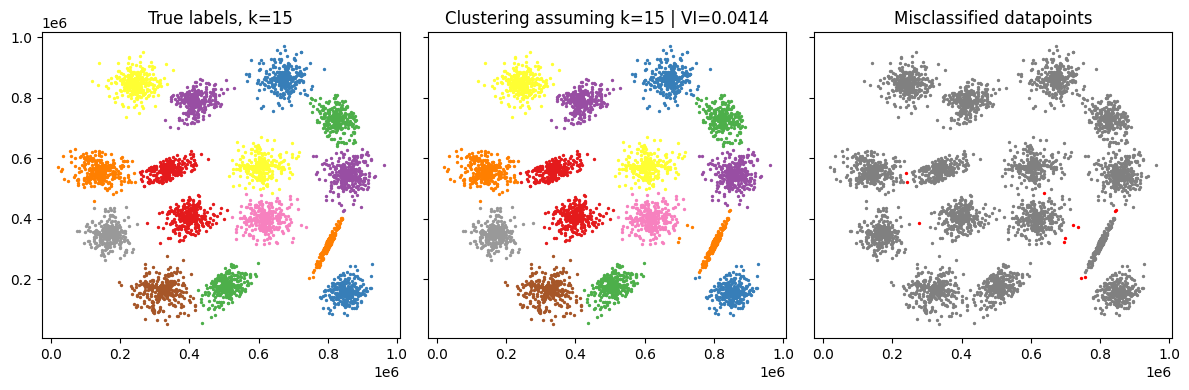

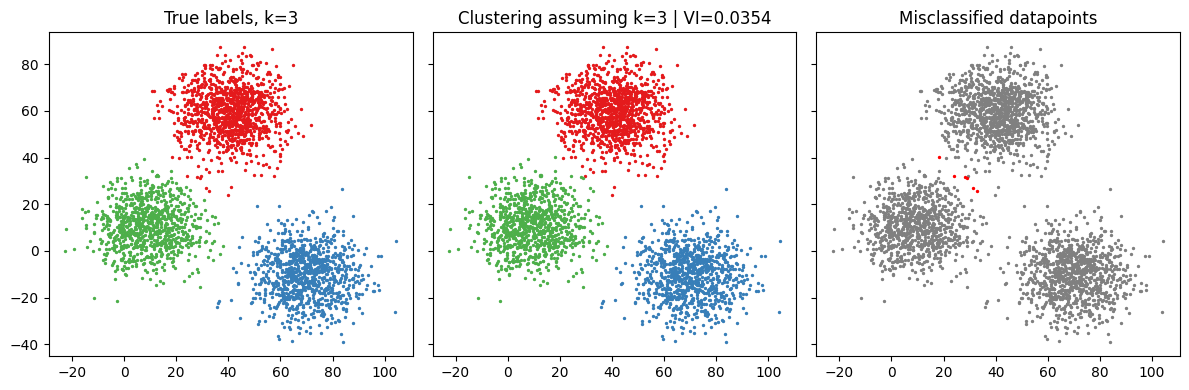

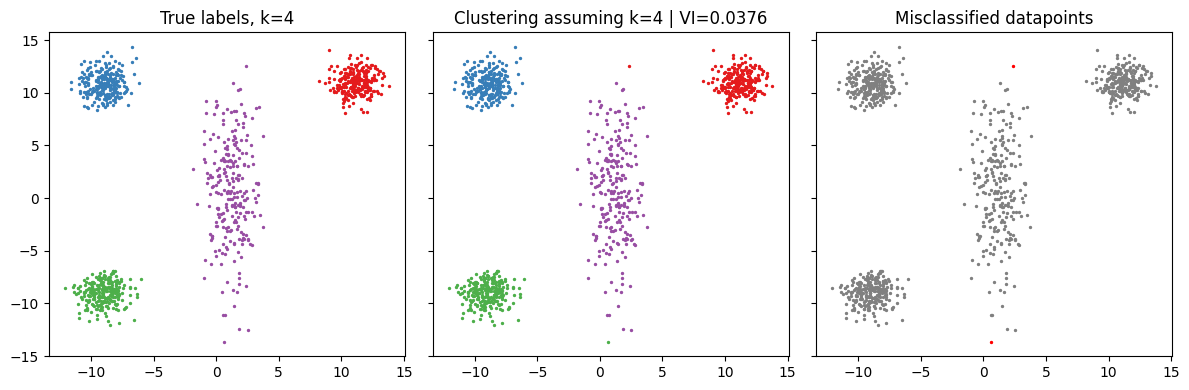

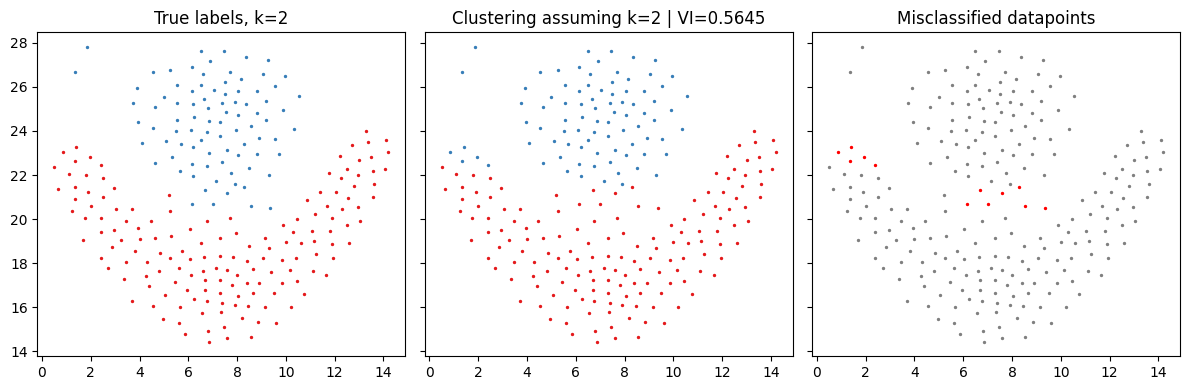

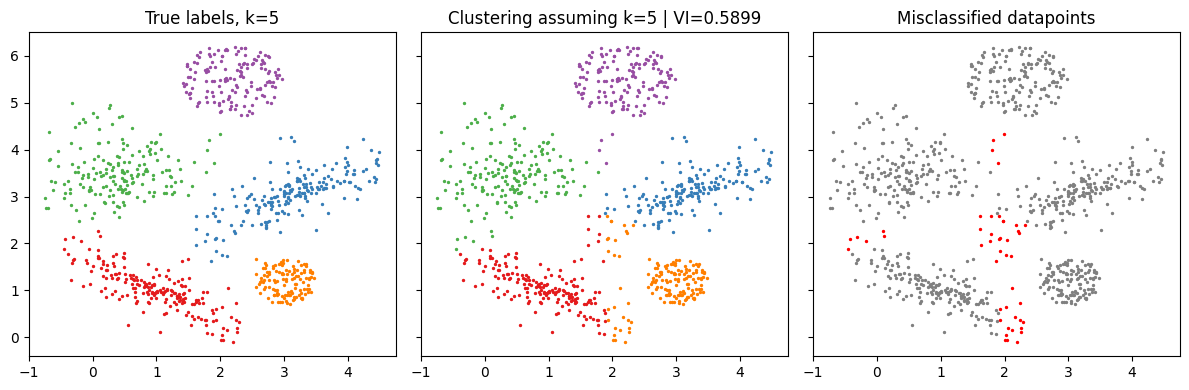

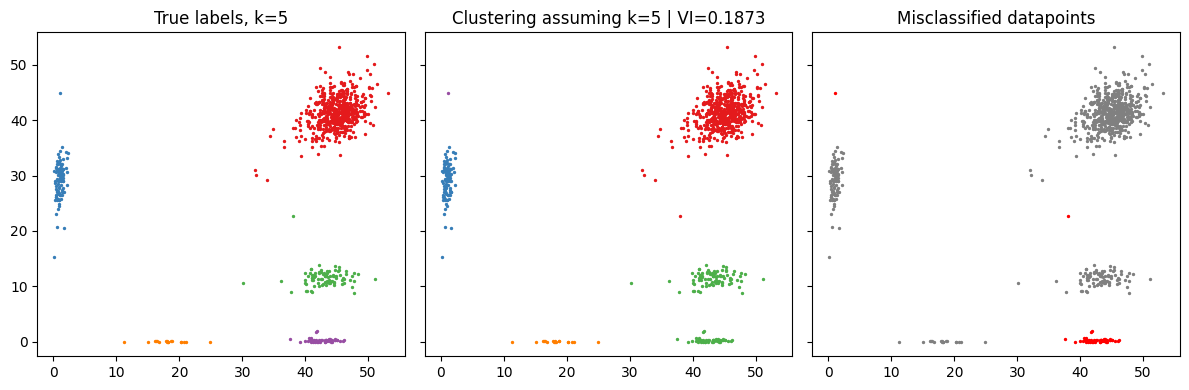

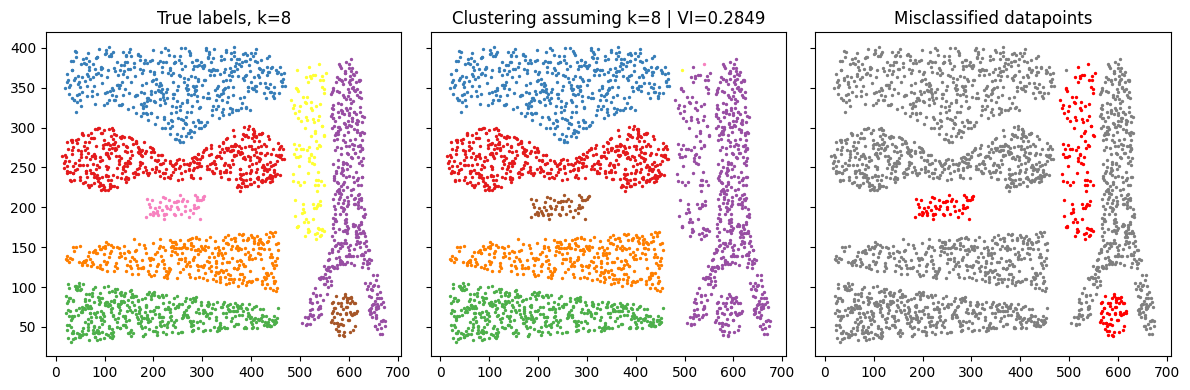

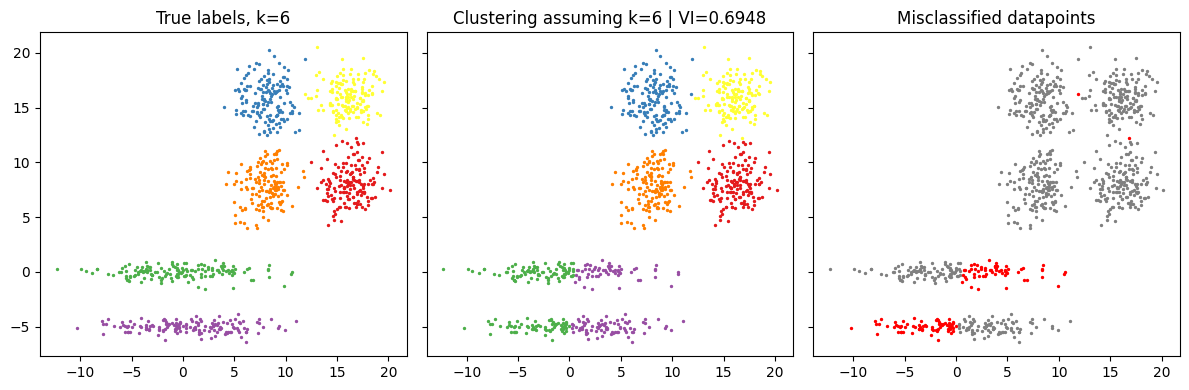

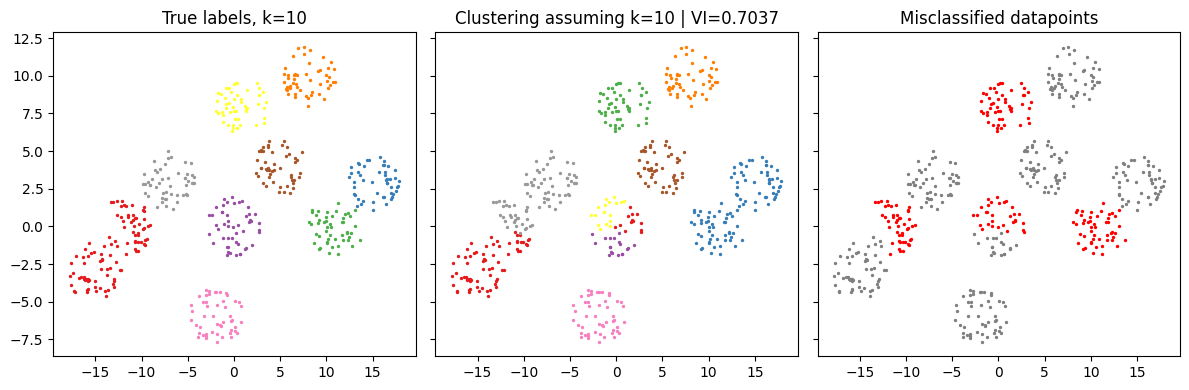

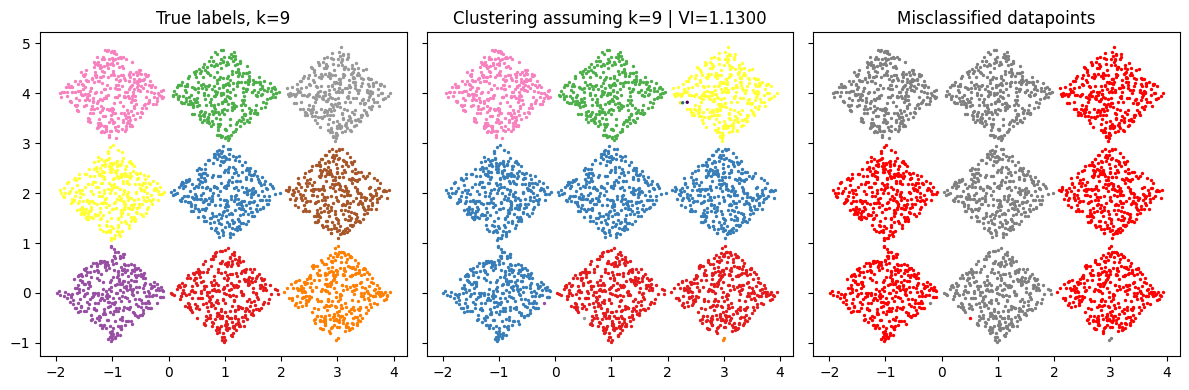

In [55]:
for exp_example in exp_examples:
    fig, misclassified = show_exp_examples(exp_example)
    fig.show()

- Think about each paragraph's purpose / main point (mainly in results?) (and try to fit in the figures and tables and try to tell the story with the figures and tables)
- Make this nice new plot
- 